In [107]:
import pandas  as pd
import matplotlib.pyplot as plt 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute  import SimpleImputer,KNNImputer,IterativeImputer
from sklearn.tree import DecisionTreeRegressor
from seedtools import load_seed,dropper,mapper_auto
import numpy  as np

In [74]:
data = load_seed("data_science_job.csv",quiet=True).data
data["gender_"] =  data["gender"].map({"Male":1,"Female":0})
data =  dropper(data,["enrollee_id","city"])
data.head(3)

,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,training_hours,target,gender_
0,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,20.0,NaN,NaN,36.0,1.0,1.0
1,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15.0,50-99,Pvt Ltd,47.0,0.0,1.0
2,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5.0,NaN,NaN,83.0,0.0,NaN


In [45]:
data.isnull().mean() *100

enrollee_id                0.000000
city                       0.000000
city_development_index     2.500261
gender                    23.530640
relevent_experience        0.000000
enrolled_university        2.014824
education_level            2.401086
major_discipline          14.683161
experience                 0.339284
company_size              30.994885
company_type              32.049274
training_hours             3.998330
target                     0.000000
gender_                   24.527612
dtype: float64

### Drop columns
=> only when removed data is less than equal to <= 5%and we are left with 95% <br />
=> ratio of the indivisual column should remain same after removing data

### Fillna 
=> You can use fillna also  `df[col] = df[col].fillna(<value>)`

### 1) Numerical Column

- Filling constant arbitary values 
- Filling any stats (mean , median,mode)
- Missing Indicator
- KNNImputer
- Iterative Imputer 

*- Use gridSearch {automatically select}*

#### a. Filling constant values
##### see below  the missing values are less thus all three lines are nearly same thus imputing 10 / 100 does not make much difference 

In [46]:
si1 = SimpleImputer(strategy="constant",fill_value=10.0)
si2  = SimpleImputer(strategy="constant",fill_value=100.0)

In [47]:
si1.fit(data["training_hours"].values.reshape(-1,1))
data["training_hours_10"] =  si1.transform(data["training_hours"].values.reshape(-1,1))

si2.fit(data["training_hours"].values.reshape(-1,1))
data["training_hours_100"] =  si2.transform(data["training_hours"].values.reshape(-1,1))

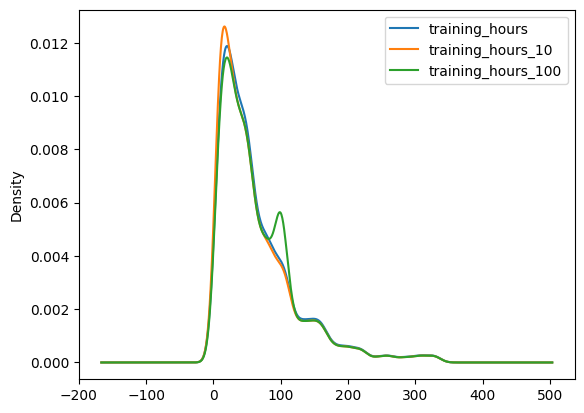

In [48]:
fig = plt.figure()
ax = fig.add_subplot(111)

data["training_hours"].plot(kind="kde",ax=ax)
data["training_hours_10"].plot(kind="kde",ax=ax)
data["training_hours_100"].plot(kind="kde",ax=ax)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

#### b. Filling any stats : mean , median , mode 
***check the variance after that if it shrinks too much it is a problem but if it aas pass then badhiya !!***

In [49]:
si3 = SimpleImputer(strategy="mean")
si4  = SimpleImputer(strategy="median")

In [50]:
si3.fit(data["training_hours"].values.reshape(-1,1))
data["training_hours_mean"] =  si3.transform(data["training_hours"].values.reshape(-1,1))

si4.fit(data["training_hours"].values.reshape(-1,1))
data["training_hours_median"] =  si4.transform(data["training_hours"].values.reshape(-1,1))


print("Orginal training hours ", data["training_hours"].var())
print("training hours mean ", data["training_hours_mean"].var())
print("training hours  median",data["training_hours_median"].var())

Orginal training hours  3586.2881933989406
training hours mean  3442.889083092338
training hours  median 3455.5844212756538


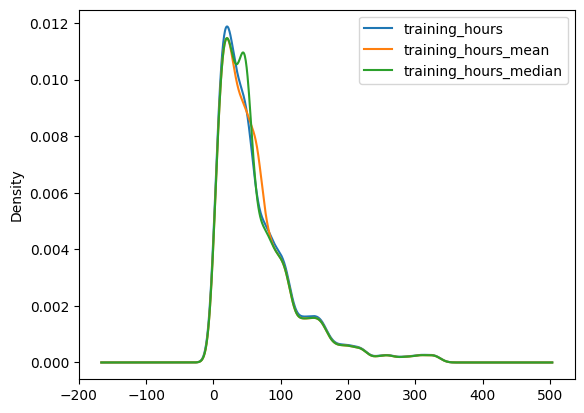

In [51]:
fig = plt.figure()
ax = fig.add_subplot(111)

data["training_hours"].plot(kind="kde",ax=ax)
data["training_hours_mean"].plot(kind="kde",ax=ax)
data["training_hours_median"].plot(kind="kde",ax=ax)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

#### c.  Missing Indicator 

by `MissingIndicator() from impute` OR `SimpleImputer(add_indicator=True)`

In [52]:
si_m = SimpleImputer(add_indicator=True)
X = si_m.fit_transform(data["training_hours"].values.reshape(-1,1))
data["training_hours_indicator"]=  X[:,1].astype(bool)

data.iloc[:,14:].head(3)

,training_hours_10,training_hours_100,training_hours_mean,training_hours_median,training_hours_indicator
0,36.0,36.0,36.0,36.0,False
1,47.0,47.0,47.0,47.0,False
2,83.0,83.0,83.0,83.0,False


#### d. KNN Imputer 

*Based On `nan_euclidean_distance` (sklearn docs) , parameters : `weights :['distance','uniform]`*

In [53]:
knn= KNNImputer(n_neighbors=4)
knn.fit(data["training_hours"].values.reshape(-1,1))
data["training_hours_knn"] =  knn.transform(data["training_hours"].values.reshape(-1,1))

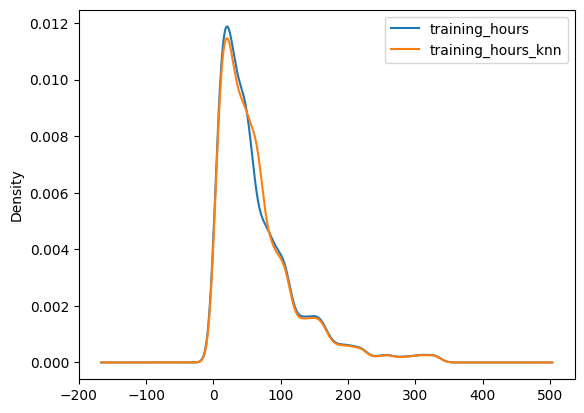

In [61]:
fig = plt.figure()
ax = fig.add_subplot(111)

data["training_hours"].plot(kind="kde",ax=ax)
data["training_hours_knn"].plot(kind="kde",ax=ax)
lines, labels = ax.get_legend_handles_labels()
ax.legend(lines, labels, loc='best')

#### e. Iterative Imputer 
*finding relation between other features and predicting the missing value*

In [108]:
data_ = pd.DataFrame({
    'age': [25, 30, 35, 40, 45, 50, 55, 60],
    'salary': [50000, 52000, 54000, 56000, 58000, 60000, 62000, 64000],
    "placed":[0,1,0,1,0,1,1,0]
})
missing_indices = np.random.choice(data_.index, size=3)
data_.loc[missing_indices, 'age'] = np.nan


In [121]:
imputer = IterativeImputer(estimator=DecisionTreeRegressor(), max_iter=10, random_state=0)
imputed_data = imputer.fit_transform(data_[["age","salary"]])
data_["imputed"] =  imputed_data[:,0]
data_.head()

,age,salary,placed,imputed
0,25.0,50000,0,25.0
1,30.0,52000,1,30.0
2,35.0,54000,0,35.0
3,40.0,56000,1,40.0
4,NaN,58000,0,40.0


## 2) Categorical Columnn
***check the kde plot after that that it must nealy be same***
- constant value 

#### a. Constant value 

In [54]:
si5 = SimpleImputer(strategy="constant",fill_value="Female") # filling female
si6 = SimpleImputer(strategy="constant",fill_value="Other") # filling other 

In [55]:
si5.fit(data["gender"].values.reshape(-1,1))
data["gender_female"] =  si5.transform(data["gender"].values.reshape(-1,1)).ravel()

si6.fit(data["gender"].values.reshape(-1,1))
data["gender_others"] =  si6.transform(data["gender"].values.reshape(-1,1)).ravel()

<Axes: xlabel='gender_others'>

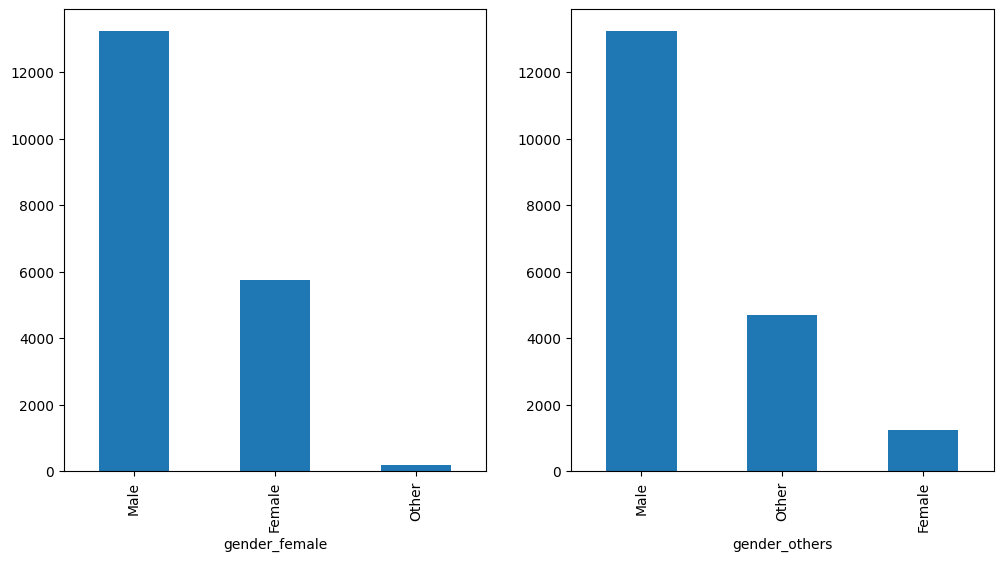

In [56]:
plt.figure(figsize=(12,6))

plt.subplot(1,2,1)
data['gender_female'].value_counts().plot(kind='bar')

plt.subplot(1,2,2)
data['gender_others'].value_counts().plot(kind='bar')


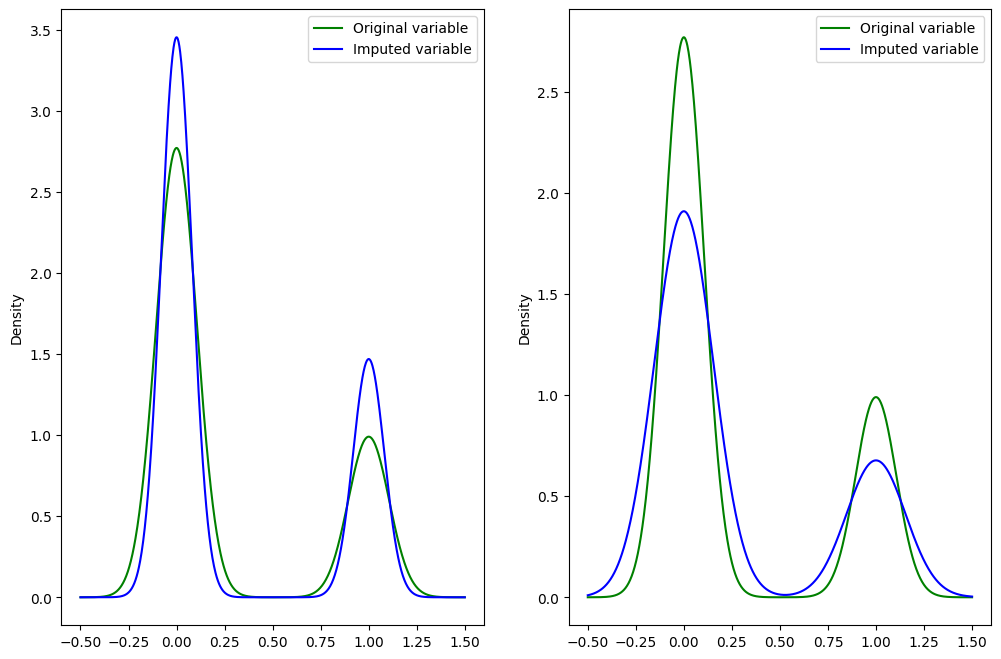

In [57]:
fig = plt.figure(figsize=(12,8))

ax =  fig.add_subplot(1,2,1)

data[data["gender"]=='Female']['target'].plot(kind="kde",ax=ax,color='green')
data[data["gender_female"]=='Female']['target'].plot(kind="kde",ax=ax,color='blue')
lines, labels = ax.get_legend_handles_labels()
labels = ['Original variable', 'Imputed variable']
ax.legend(lines, labels, loc='best')

ax = fig.add_subplot(1,2,2)

data[data["gender"]=='Female']['target'].plot(kind="kde",ax=ax,color='green')
data[data["gender_female"]=='Other']['target'].plot(kind="kde",ax=ax,color='blue')
lines, labels = ax.get_legend_handles_labels()
labels = ['Original variable', 'Imputed variable']
ax.legend(lines, labels, loc='best')

##### the result is poor , [ just see the mode filling :  perfect result]

In [58]:
data.gender.mode()

0    Male
Name: gender, dtype: object

#### b. Mode filling /most_frequent 
***They can be different but most of the times they are same***

In [59]:
si7 = SimpleImputer(strategy="most_frequent")
si7.fit(data.gender.values.reshape(-1,1))

data["gender_new"] =  si7.transform(data.gender.values.reshape(-1,1)).ravel()

si7.statistics_

array(['Male'], dtype=object)

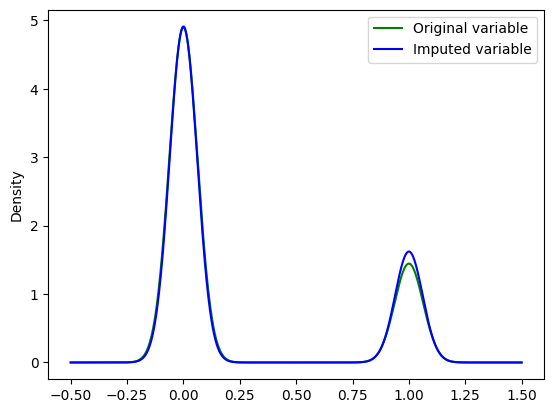

In [60]:
fig = plt.figure()
ax = fig.add_subplot(111)

data[data["gender"]=='Male']['target'].plot(kind="kde",ax=ax,color='green')
data[data["gender_new"]=='Male']['target'].plot(kind="kde",ax=ax,color='blue')
lines, labels = ax.get_legend_handles_labels()
labels = ['Original variable', 'Imputed variable']
ax.legend(lines, labels, loc='best')